In [1]:
import torch 



In [57]:
a = torch.load('buffer/CIFAR10/ConvNet/replay_buffer_0.pt')

In [66]:
target_params = a[1][23]
student_params = a[1][20]
middle_params = a[1][21]

In [67]:
target_params = torch.cat([p.data.reshape(-1) for p in target_params], 0)
student_params = torch.cat([p.data.reshape(-1) for p in student_params], 0)
middle_params = torch.cat([p.data.reshape(-1) for p in middle_params], 0)

In [68]:
param_dist = torch.nn.functional.mse_loss(student_params, target_params, reduction="sum")
param_loss = torch.nn.functional.mse_loss(student_params, middle_params, reduction="sum")

In [69]:
num_params = student_params.shape[0]

In [80]:
param_loss/(param_dist+1)

tensor(0.0592)

In [78]:
param_dist

tensor(0.3257)

In [20]:
import torch
import torch.nn as nn

class Function(torch.nn.Module):
    def __init__(self):
        super(Function, self).__init__()
        self.Linear = torch.nn.Linear(1,1)
    def forward(self, input):
        output = self.Linear(input)
        return output

func = Function()

x= torch.tensor([1.0])
x.requires_grad=False
y = func(x) ** 2

y.backward(retain_graph=True)
y.backward()

/home/jiale001/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  ../torch/csrc/autograd/engine.cpp:985.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [2]:
for para in func.parameters():
    print(para)
    print(para.grad)

Parameter containing:
tensor([[-0.1038]], requires_grad=True)
tensor([[-4.3790]])
Parameter containing:
tensor([-0.9909], requires_grad=True)
tensor([-4.3790])


In [16]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(0,10,(3,5),dtype=torch.float).softmax(dim=1)
output = loss(input, target)
output.backward()

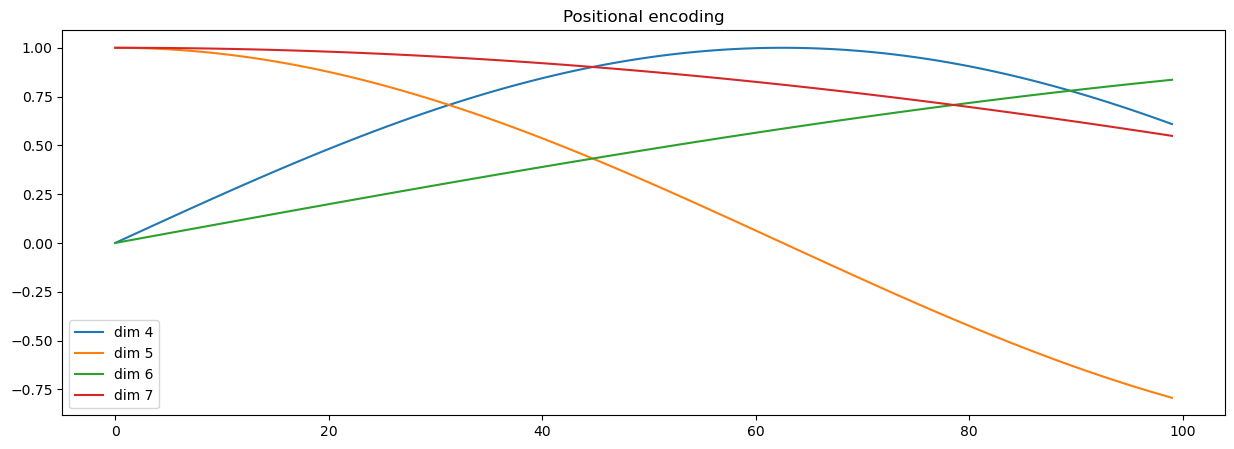

In [23]:
"""
---
title: Fixed Positional Encodings
summary: >
  Implementation with explanation of fixed positional encodings as
  described in paper Attention is All You Need.
---
# Fixed Positional Encodings
The positional encoding encodes the position along the sequence into
 a vector of size `d_model`.
\begin{align}
PE_{p,2i} &= sin\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg) \\
PE_{p,2i + 1} &= cos\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)
\end{align}
Where $1 \leq 2i, 2i + 1 \leq d_{model}$
 are the feature indexes in the encoding, and $p$ is the position.
"""

import math

import numpy as np
import torch
import torch.nn as nn


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout_prob: float, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_prob)

        self.register_buffer('positional_encodings', get_positional_encoding(d_model, max_len), False)

    def forward(self, x: torch.Tensor):
        pe = self.positional_encodings[:x.shape[0]].detach().requires_grad_(False)
        x = x + pe
        x = self.dropout(x)
        return x


def get_positional_encoding(d_model: int, max_len: int = 5000):
    # Empty encodings vectors
    encodings = torch.zeros(max_len, d_model)
    # Position indexes
    position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
    # $2 * i$
    two_i = torch.arange(0, d_model, 2, dtype=torch.float32)
    # $10000^{\frac{2i}{d_{model}}}$
    div_term = torch.exp(two_i * -(math.log(10000.0) / d_model))
    # $PE_{p,2i} = sin\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)$
    encodings[:, 0::2] = torch.sin(position * div_term)
    # $PE_{p,2i + 1} = cos\Bigg(\frac{p}{10000^{\frac{2i}{d_{model}}}}\Bigg)$
    encodings[:, 1::2] = torch.cos(position * div_term)

    # Add batch dimension
    encodings = encodings.unsqueeze(1).requires_grad_(False)

    return encodings


def _test_positional_encoding():
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, 5))
    pe = get_positional_encoding(20, 100)
    plt.plot(np.arange(100), pe[:, 0, 4:8].numpy())
    plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])
    plt.title("Positional encoding")
    plt.show()


if __name__ == '__main__':
    _test_positional_encoding()